In [30]:
#load required packages
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_curve,auc,classification_report
from sklearn.svm import SVC
pd.set_option('display.max_columns', None)

In [31]:
#load required helper functions
from wrappers.helper_functions import (feature_selection,regularized_mean_encoding,
                                       plot_confusion_matrix,ABS_SHAP,Decile_Analysis,Eval_Statistics)

In [32]:
#load dataset
employee_data = pd.read_csv('employee-attrition.csv',sep='\t')

In [33]:
#check for nulls and inconsistencies
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [34]:
#distribution of categorical variables
employee_data[['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime','Attrition']].describe()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime,Attrition
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,3,3,6,2,9,3,2,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No,No
freq,1043,961,606,882,326,673,1054,1233


In [35]:
#Total Attrition Rate
counts = employee_data['Attrition'].value_counts()
AtrritonRate = counts[1] / len(employee_data)

print("Atrriton Rate: ",round(AtrritonRate,4)*100)

Atrriton Rate:  16.12


In [36]:
#binary encoding for categorical variables -- Gender, OverTime, Attrition (Target)
employee_data['Gender'] = employee_data['Gender'].replace({'Male': 1, 'Female': 0})
employee_data['OverTime'] = employee_data['OverTime'].replace({'Yes': 1, 'No': 0})
employee_data['Attrition'] = employee_data['Attrition'].replace({'Yes': 1, 'No': 0})

In [37]:
#distribution of Business Travel variable
employee_data['BusinessTravel'].value_counts()

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

In [38]:
#distribution of Dept variable
employee_data['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [39]:
#distribution of Marital Status variable
employee_data['MaritalStatus'].value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [40]:
#one-hot encode BusinessTravel, Department, MaritalStatus
employee_data = pd.get_dummies(employee_data, columns=['BusinessTravel','Department','MaritalStatus'])

In [41]:
#check dataset transformations
employee_data

,Age,Attrition,DailyRate,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,Life Sciences,1,1,2,0,94,3,2,Sales Executive,4,5993,19479,8,Y,1,11,3,1,80,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,0,1
1,49,0,279,8,1,Life Sciences,1,2,3,1,61,2,2,Research Scientist,2,5130,24907,1,Y,0,23,4,4,80,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0
2,37,1,1373,2,2,Other,1,4,4,1,92,2,1,Laboratory Technician,3,2090,2396,6,Y,1,15,3,2,80,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,1
3,33,0,1392,3,4,Life Sciences,1,5,4,0,56,3,1,Research Scientist,3,2909,23159,1,Y,1,11,3,3,80,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0
4,27,0,591,2,1,Medical,1,7,1,1,40,3,1,Laboratory Technician,2,3468,16632,9,Y,0,12,3,4,80,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,Medical,1,2061,3,1,41,4,2,Laboratory Technician,4,2571,12290,4,Y,0,17,3,3,80,1,17,3,3,5,2,0,3,0,1,0,0,1,0,0,1,0
1466,39,0,613,6,1,Medical,1,2062,4,1,42,2,3,Healthcare Representative,1,9991,21457,4,Y,0,15,3,1,80,1,9,5,3,7,7,1,7,0,0,1,0,1,0,0,1,0
1467,27,0,155,4,3,Life Sciences,1,2064,2,1,87,4,2,Manufacturing Director,2,6142,5174,1,Y,1,20,4,2,80,1,6,0,3,6,2,0,3,0,0,1,0,1,0,0,1,0
1468,49,0,1023,2,3,Medical,1,2065,4,1,63,2,2,Sales Executive,2,5390,13243,2,Y,0,14,3,4,80,0,17,3,2,9,6,0,8,0,1,0,0,0,1,0,1,0


In [42]:
#drop excess variables for dimensionality reduction
employee_data.drop(['BusinessTravel_Non-Travel','Department_Human Resources','MaritalStatus_Divorced'],axis=1,inplace=True)

In [43]:
#check for uniformily distributed variables
employee_data.describe().loc[['mean', 'max', 'min'], :]

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single
mean,36.92381,0.161224,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,0.6,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,0.282993,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.79932,2.761224,7.008163,4.229252,2.187755,4.123129,0.188435,0.709524,0.653741,0.303401,0.457823,0.319728
max,60.00000,1.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,1.0,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,1.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.00000,4.000000,40.000000,18.000000,15.000000,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,18.00000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.0,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
#drop uniformily distributed variables
employee_data.drop(['EmployeeNumber','EmployeeCount','Over18','StandardHours'],axis=1,inplace=True)

In [45]:
#append target at the end for clear visualization of the dataset
Target = employee_data.pop('Attrition')
employee_data.insert(len(employee_data.columns), 'Attrition', Target)

In [46]:
#check dataset transformations
employee_data

,Age,DailyRate,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single,Attrition
0,41,1102,1,2,Life Sciences,2,0,94,3,2,Sales Executive,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,0,1,1
1,49,279,8,1,Life Sciences,3,1,61,2,2,Research Scientist,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,1,0,0
2,37,1373,2,2,Other,4,1,92,2,1,Laboratory Technician,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,1,1,0,0,1,1
3,33,1392,3,4,Life Sciences,4,0,56,3,1,Research Scientist,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,1,0,0
4,27,591,2,1,Medical,1,1,40,3,1,Laboratory Technician,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,Medical,3,1,41,4,2,Laboratory Technician,4,2571,12290,4,0,17,3,3,1,17,3,3,5,2,0,3,1,0,1,0,1,0,0
1466,39,613,6,1,Medical,4,1,42,2,3,Healthcare Representative,1,9991,21457,4,0,15,3,1,1,9,5,3,7,7,1,7,0,1,1,0,1,0,0
1467,27,155,4,3,Life Sciences,2,1,87,4,2,Manufacturing Director,2,6142,5174,1,1,20,4,2,1,6,0,3,6,2,0,3,0,1,1,0,1,0,0
1468,49,1023,2,3,Medical,4,1,63,2,2,Sales Executive,2,5390,13243,2,0,14,3,4,0,17,3,2,9,6,0,8,1,0,0,1,1,0,0


In [47]:
#split the dataset into training and testing datasets
train, test = train_test_split(employee_data,
                                   test_size=0.2,
                                   stratify=employee_data['Attrition'],
                                   random_state=42)

In [48]:
#apply regularized mean encoding on EducationField & JobRole
train,test = regularized_mean_encoding(train,test,'EducationField',1)
train,test = regularized_mean_encoding(train,test,'JobRole',1)

In [49]:
#Find spearman coorelation between variables
corr_mtx = train.corr(method='spearman')

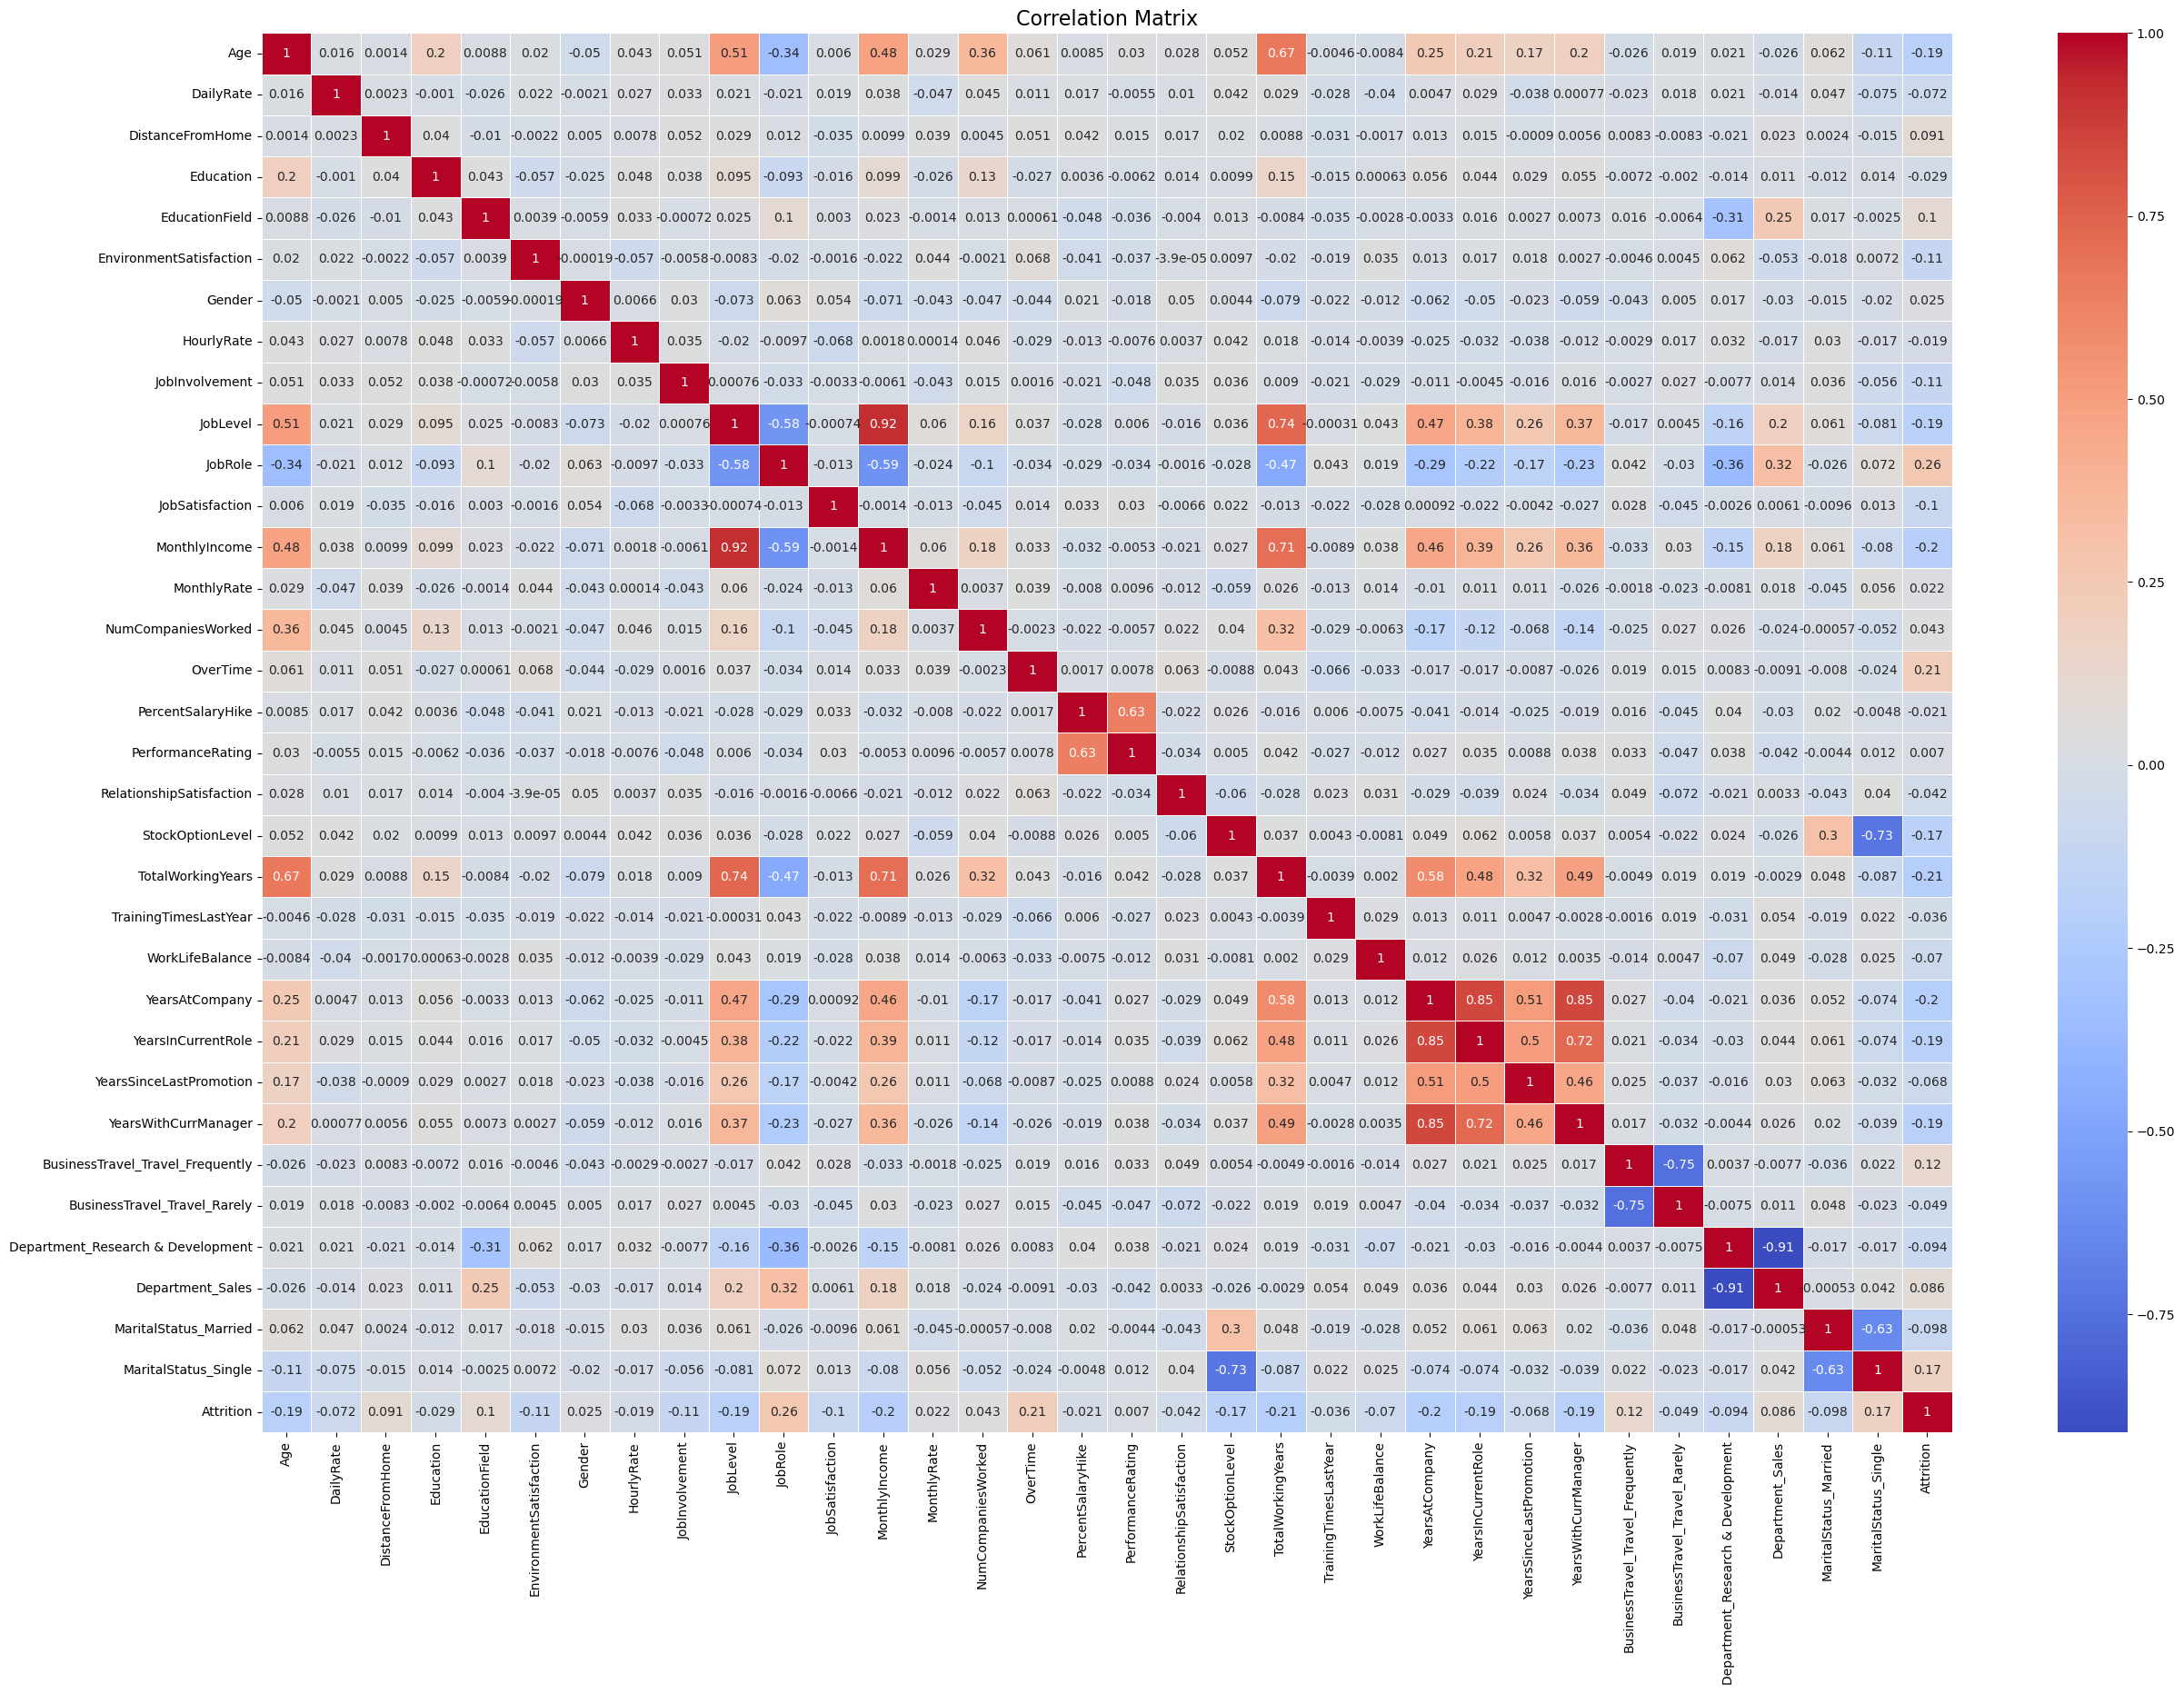

In [50]:
#plot corr matrix
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [51]:
#Find pearson coorelation between variables
corr_mtx = train.corr()

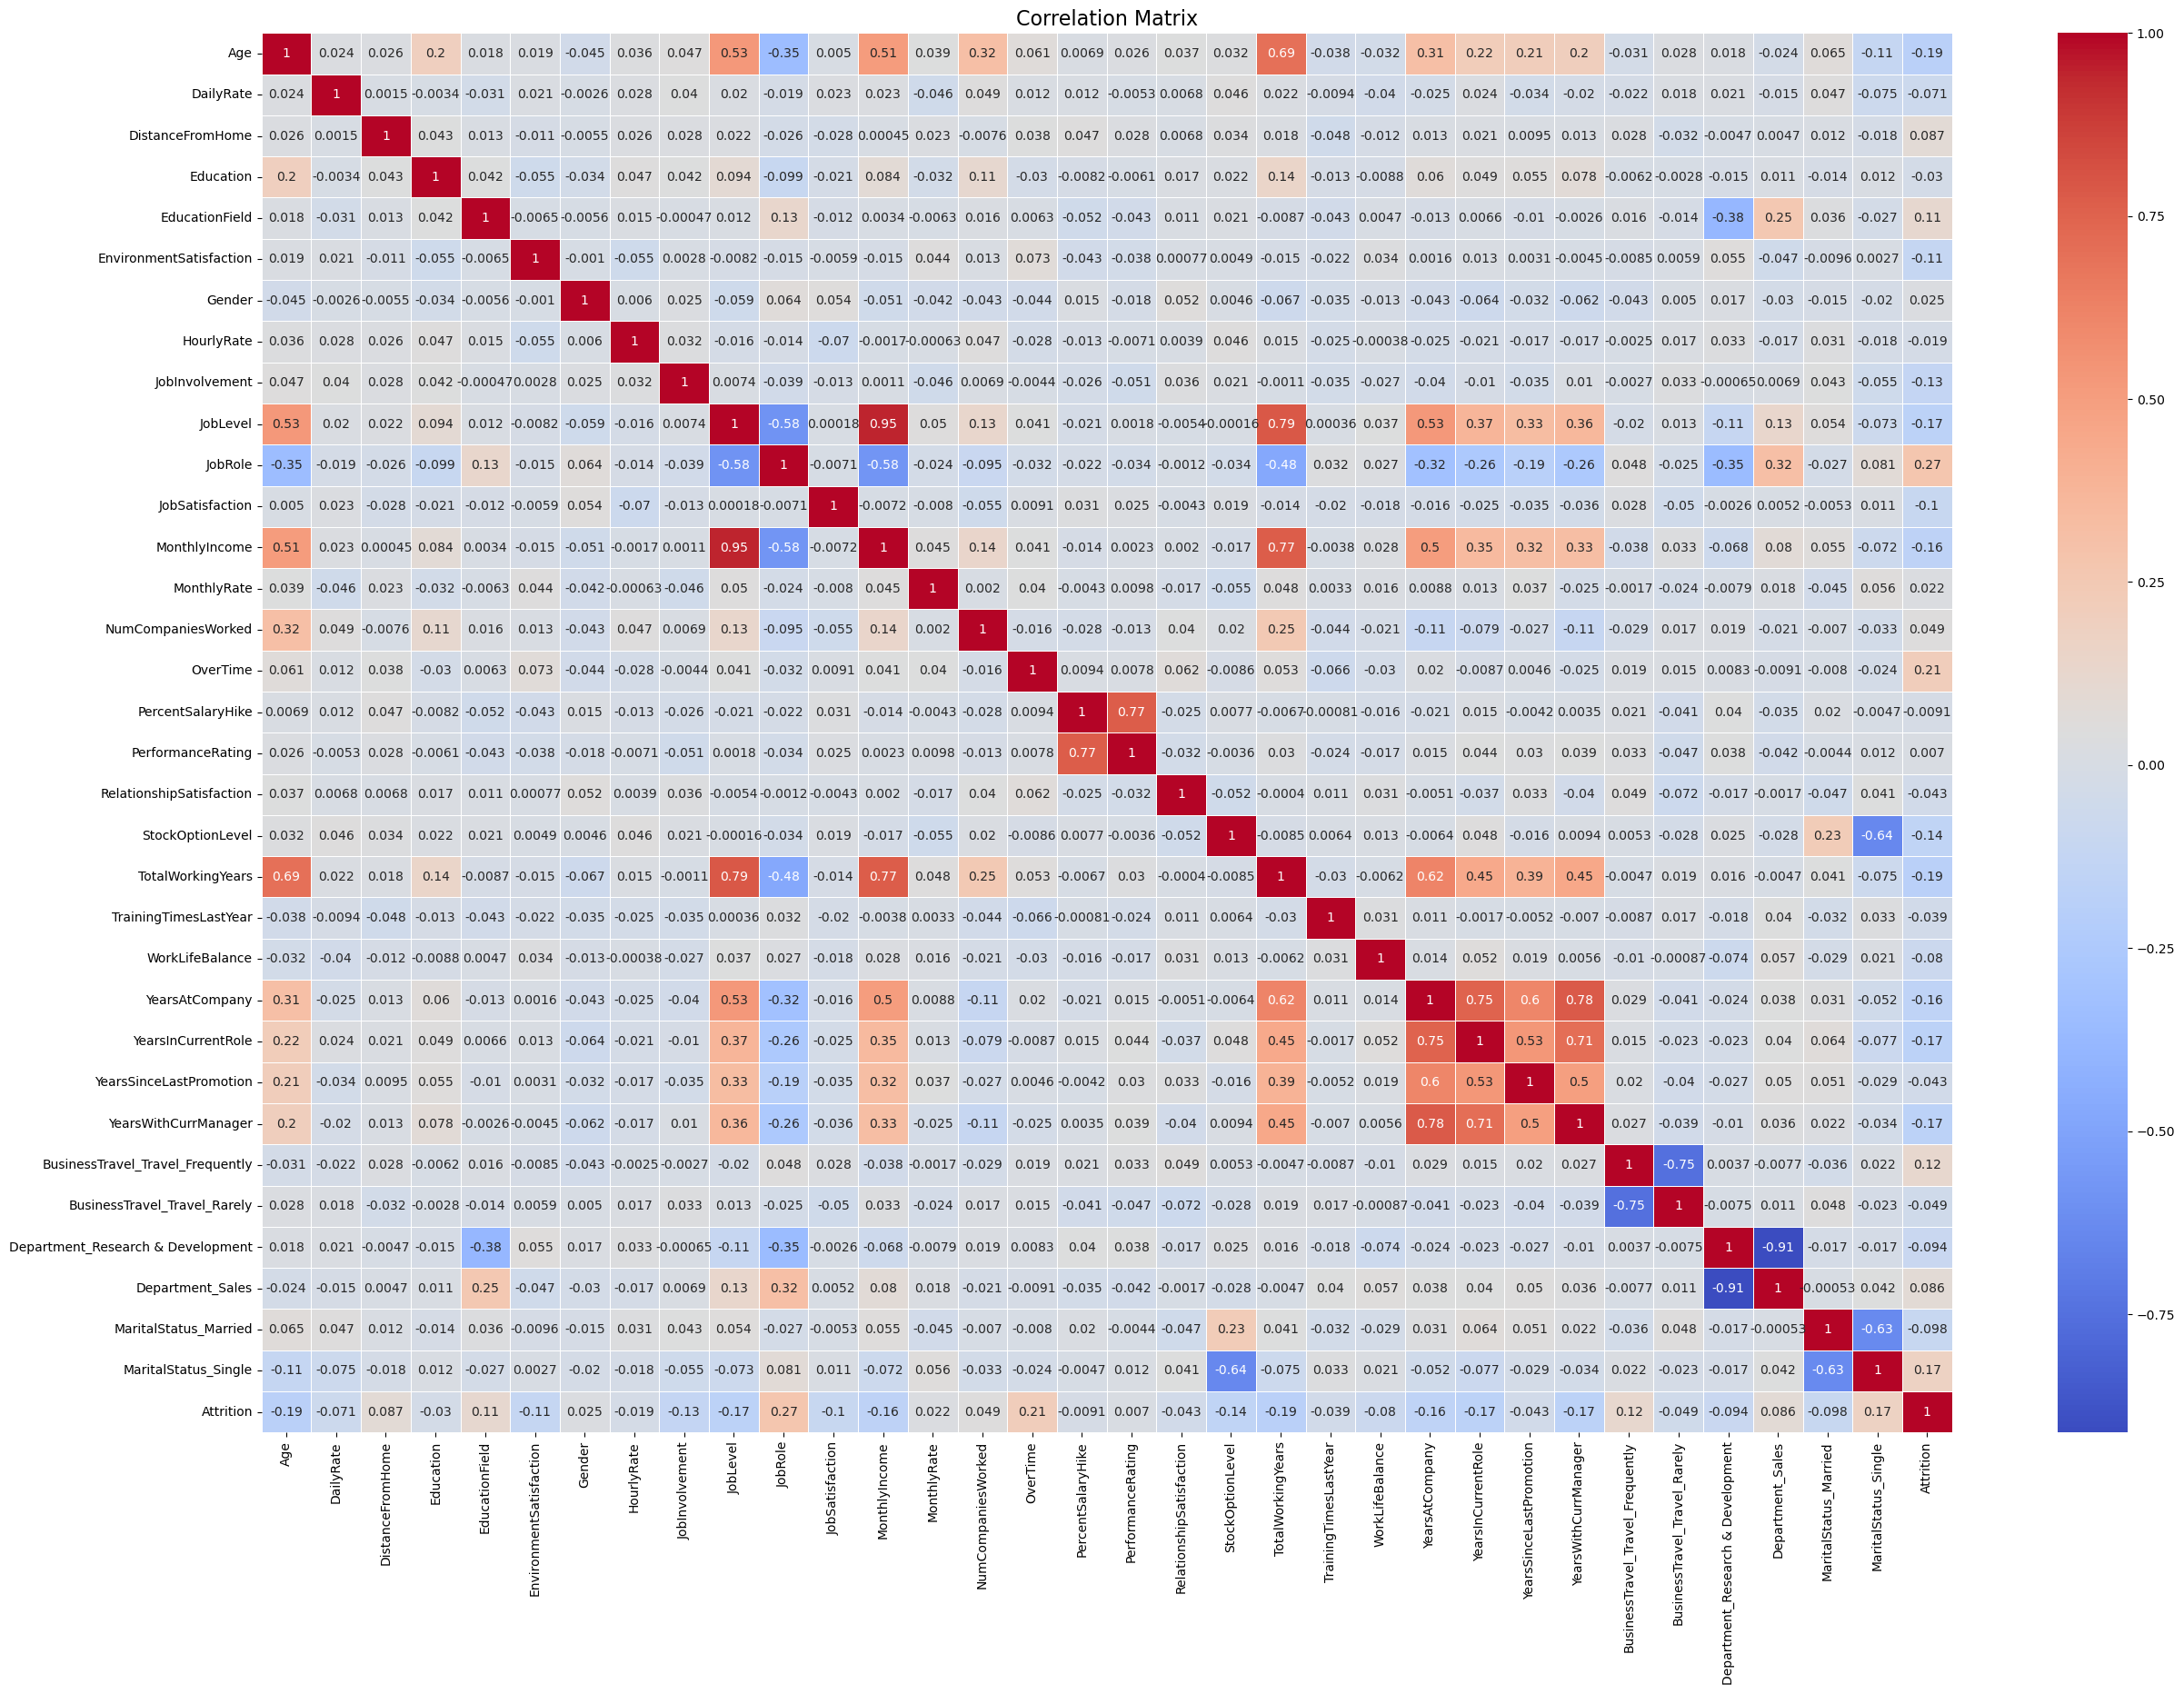

In [52]:
# plot corr matrix
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [53]:
#drop coorealted variables
train.drop(['MonthlyIncome'],axis=1,inplace=True)
test.drop(['MonthlyIncome'],axis=1,inplace=True)

In [54]:
#select top features using Information Gain
selected_features = feature_selection(train, 33, 'Attrition')
selected_features = feature_selection(train, 30, 'Attrition')
selected_features = feature_selection(train, 27, 'Attrition')
selected_features = feature_selection(train, 24, 'Attrition')

For 33 variables TPR is  77.37
For 33 variables FPR is  30.3
For 30 variables TPR is  74.21
For 30 variables FPR is  27.800000000000004
For 27 variables TPR is  73.16
For 27 variables FPR is  30.599999999999998
For 24 variables TPR is  76.32
For 24 variables FPR is  30.599999999999998


In [55]:
#Selected Variables
train = feature_selection(train, 27, 'Attrition')
test = test[list(train.columns.values)]

For 27 variables TPR is  73.68
For 27 variables FPR is  28.199999999999996


In [56]:
#view selected variables
train

,JobRole,OverTime,Age,TotalWorkingYears,YearsWithCurrManager,WorkLifeBalance,EnvironmentSatisfaction,DistanceFromHome,DailyRate,RelationshipSatisfaction,YearsInCurrentRole,JobInvolvement,YearsAtCompany,EducationField,JobLevel,NumCompaniesWorked,JobSatisfaction,HourlyRate,YearsSinceLastPromotion,MonthlyRate,TrainingTimesLastYear,StockOptionLevel,PercentSalaryHike,Education,MaritalStatus_Single,BusinessTravel_Travel_Frequently,Gender,Attrition
1194,0.061447,0,47,29,2,3,2,2,1225,3,2,4,3,0.156587,4,6,2,47,1,21086,2,3,14,4,0,0,0,0
128,0.269267,0,22,3,1,3,3,2,594,3,1,3,2,0.216910,1,0,4,100,2,19299,2,1,14,1,0,0,1,0
810,0.061447,0,46,23,9,3,1,3,406,4,9,3,12,0.216012,4,3,3,52,4,15596,3,1,12,1,0,0,1,0
478,0.412485,0,25,7,6,3,2,13,622,3,4,3,7,0.134689,1,1,3,40,0,26376,1,0,11,1,0,0,1,0
491,0.269267,1,43,10,7,3,4,9,1001,2,7,3,8,0.134689,2,3,3,72,4,19627,3,1,13,5,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,0.412485,1,23,3,2,3,3,7,427,2,2,3,3,0.156587,1,1,4,99,0,25103,2,1,21,3,0,0,1,1
963,0.179422,0,38,11,7,3,2,2,1009,4,7,3,7,0.156587,2,3,1,31,1,19461,3,1,15,2,0,0,0,0
734,0.269267,0,22,4,1,2,2,8,217,1,3,1,4,0.156587,1,1,1,94,1,6881,3,1,15,1,0,0,1,0
1315,0.131953,1,36,15,0,3,4,2,430,4,0,3,1,0.081930,2,4,2,73,0,19573,2,1,22,4,0,0,0,0


In [52]:
#Split target arrays
y_train = train['Attrition']
X_train = train.drop(['Attrition'],axis=1)
y_test = test['Attrition']
X_test = test.drop(['Attrition'],axis=1)

In [53]:
#Train svm model
svm_model = SVC(probability=True)
svm_model.fit(X_train,y_train)

SVC(probability=True)

In [54]:
#Train Bagging Model
rf_model = RandomForestClassifier(n_estimators = 50)
rf_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [55]:
#Train Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=50)
gb_model.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=50)

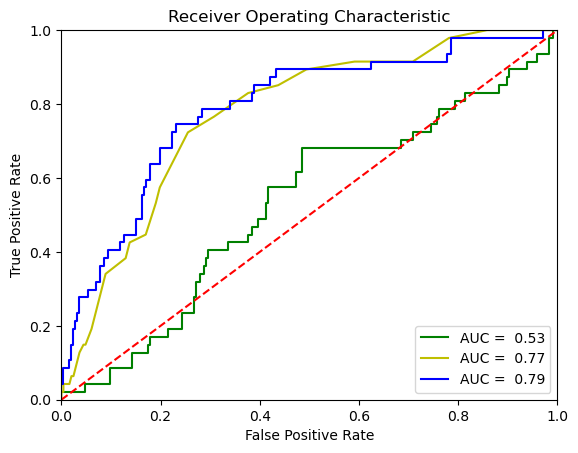

In [56]:
#plot ROC chart
svm_probs = svm_model.predict_proba(X_test)
rf_probs = rf_model.predict_proba(X_test)
gb_probs = gb_model.predict_proba(X_test)

svm_preds = svm_probs[:,1]
rf_preds = rf_probs[:,1]
gb_preds = gb_probs[:,1]

svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, svm_preds)
svm_roc_auc = auc(svm_fpr, svm_tpr)

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_preds)
rf_roc_auc = auc(rf_fpr, rf_tpr)

gb_fpr, gb_tpr, gb_threshold = roc_curve(y_test, gb_preds)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(svm_fpr, svm_tpr, 'g', label = 'AUC =  %0.2f' % svm_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'y', label = 'AUC =  %0.2f' % rf_roc_auc)
plt.plot(gb_fpr, gb_tpr, 'b', label = 'AUC =  %0.2f' % gb_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [57]:
#find optimal cut-off
optimal_idx = np.argmax(rf_tpr - rf_fpr)
rf_optimal_threshold = rf_threshold[optimal_idx]
optimal_idx = np.argmax(gb_tpr - gb_fpr)
gb_optimal_threshold = gb_threshold[optimal_idx]

In [58]:
gb_optimal_threshold

0.16248899171172748

In [59]:
#Define classes based on cut-off value
threshold = gb_optimal_threshold
p_test = (gb_model.predict_proba(X_test)[:, 1] > 0.15).astype('float')

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       247
           1       0.36      0.74      0.49        47

    accuracy                           0.75       294
   macro avg       0.65      0.75      0.66       294
weighted avg       0.85      0.75      0.78       294



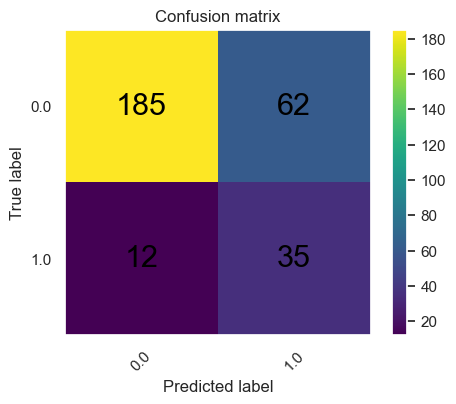

In [60]:
#plot Confusion Matrix
print(classification_report(y_test, p_test))
sns.set(rc={'figure.figsize':(5,4)})
cnf_matrix = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cnf_matrix, np.unique(p_test))

In [61]:
#find stats
Eval_Statistics(cnf_matrix)

TPR : 0.7446808510638298
FPR : 0.25101214574898784
TNR : 0.7489878542510121
FNR : 0.2553191489361702


(0.7446808510638298, 0.7489878542510121)

In [37]:
#find shap values
explainer = shap.Explainer(gb_model.predict,X_train)
shap_values = explainer(X_train)
shap_v = pd.DataFrame(shap_values.values)
shap_v.columns = X_train.columns
#shap_abs = np.abs(shap_v)
k=pd.DataFrame(shap_v.mean()).reset_index()
k.columns = ['Variable','Feature_importance']

Permutation explainer: 1177it [01:16, 14.02it/s]                                                                       


invalid value encountered in divide
invalid value encountered in divide


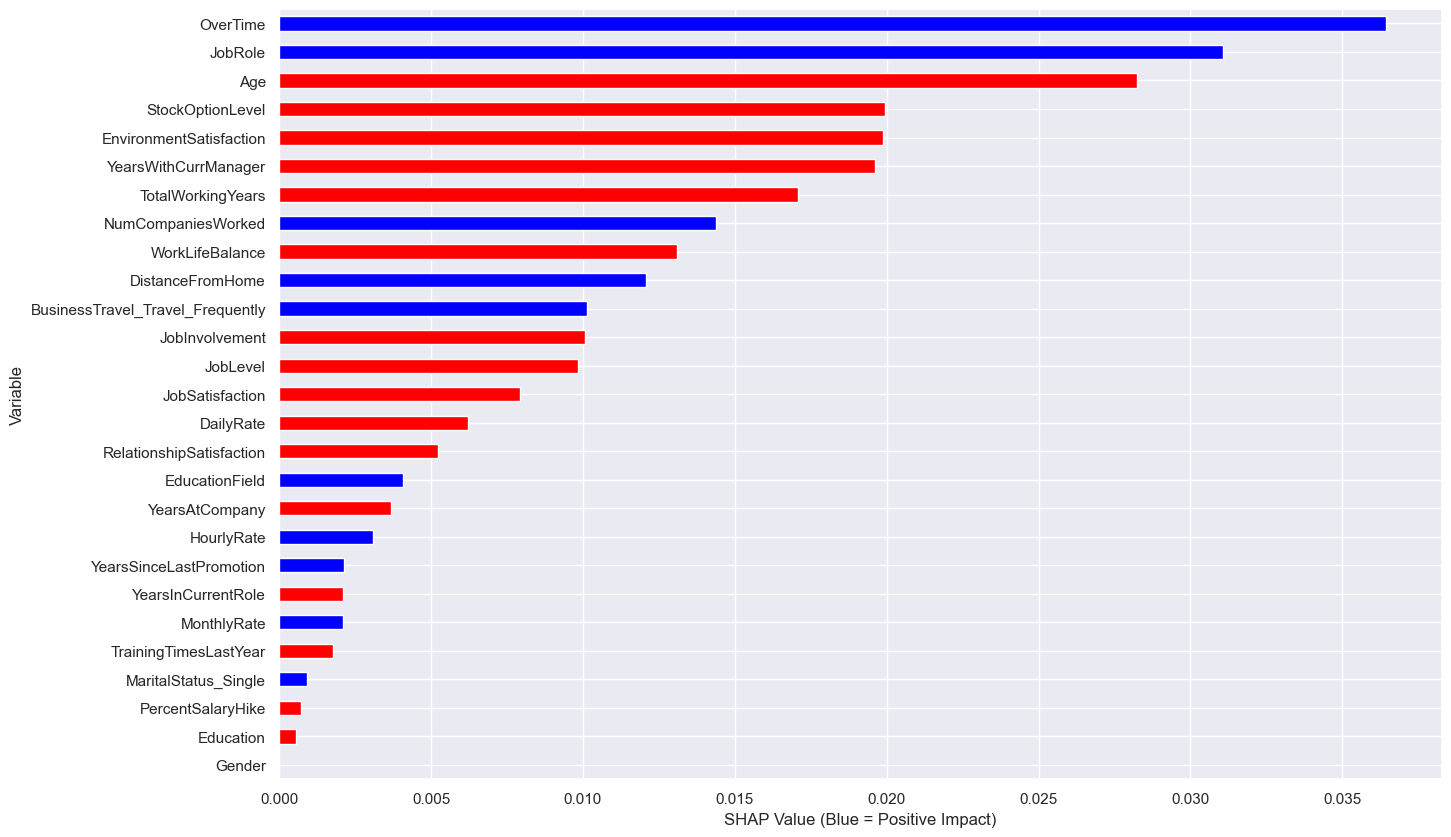

In [38]:
#find corr between shap values and variables & plot them
ABS_SHAP(shap_values,X_train)

In [39]:
#Decile chart
Decile_Analysis(test,gb_model)

,Decile,No. of Customers,Cumulative Customers,Cumulative % customers,Responders,Response Rate,percentage_responders,Gain,lift,Max Prob,Min Prob
0,1,30,30,10,14,46.666667,29.787234,29.787234,2.978723,0.922354,0.412222
1,2,29,59,20,8,27.586207,17.021277,46.808511,2.340426,0.411504,0.252007
2,3,29,88,30,11,37.931034,23.404255,70.212766,2.340426,0.250627,0.172557
3,4,30,118,40,4,13.333333,8.510638,78.723404,1.968085,0.169516,0.113926
4,5,29,147,50,4,13.793103,8.510638,87.234043,1.744681,0.112992,0.088717
5,6,29,176,60,1,3.448276,2.127660,89.361702,1.489362,0.088366,0.067561
6,7,30,206,70,1,3.333333,2.127660,91.489362,1.306991,0.067422,0.055086
7,8,29,235,80,0,0.000000,0.000000,91.489362,1.143617,0.054844,0.041881
8,9,29,264,90,3,10.344828,6.382979,97.872340,1.087470,0.041767,0.031700
9,10,30,294,100,1,3.333333,2.127660,100.000000,1.000000,0.030087,0.018629
